In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os

rename = {
        "4700-0.0": 'Age Cataract Diagnosed',
        "5901-0.0": 'Age Diabetic Retinopathy Diagnosed',
        "30780-0.0": 'LDL',
        "head_injury": 'Head Injury',
        "22038-0.0": 'Min/Week Moderate Activity',
        "20161-0.0": 'Years of Smoking',
        "alcohol_consumption": 'Alcohol consumption',
        "hypertension": 'Hypertension',
        "obesity": 'Obesity',
        "diabetes": 'Diabetes',
        "hearing_loss": 'Hearing Loss',
        "depression": 'Depression',
        "freq_friends_family_visit": 'Frequency of Friends/Family Visits',
        "24012-0.0": 'Distance to Major Road',
        "24018-0.0": 'NO2 Air Pollution',
        "24019-0.0": 'PM10 Air Pollution',
        "24006-0.0": 'PM2.5 Air Pollution',
        "24015-0.0": 'Amount of Major Roads',
        "24011-0.0": 'Traffic Intensity',
        '6138-0.0': 'Education Level',
        '845-0.0': 'Age Completed Education',
        'curr_age': 'Current Age',

}

def feature_importances_plot(path_to_experiment): 

    df = pd.read_csv(os.path.join(path_to_experiment, 'summary_stats/features.txt'))
    df['fnames'] = df['fnames'].replace(rename)
    df = df.sort_values(by='avg_fi', ascending=True)
    df = df.tail(20)
    plt.figure(figsize=(8, len(df) * 0.2))
    plt.barh(df['fnames'], df['avg_fi'], color='skyblue')
    plt.xlabel('Average Feature Importance')
    plt.title('Average Feature Importances Across Folds')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

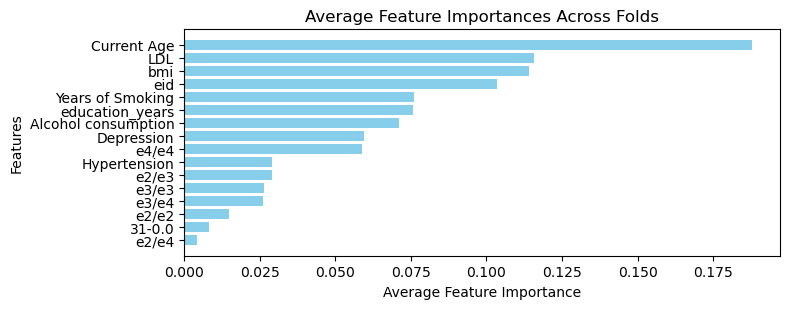

In [ ]:
path0 = './results_all/demographics_lancet2024/LDE/allages/AD/lgbm'

feature_importances_plot(path0)  # Replace with actual path

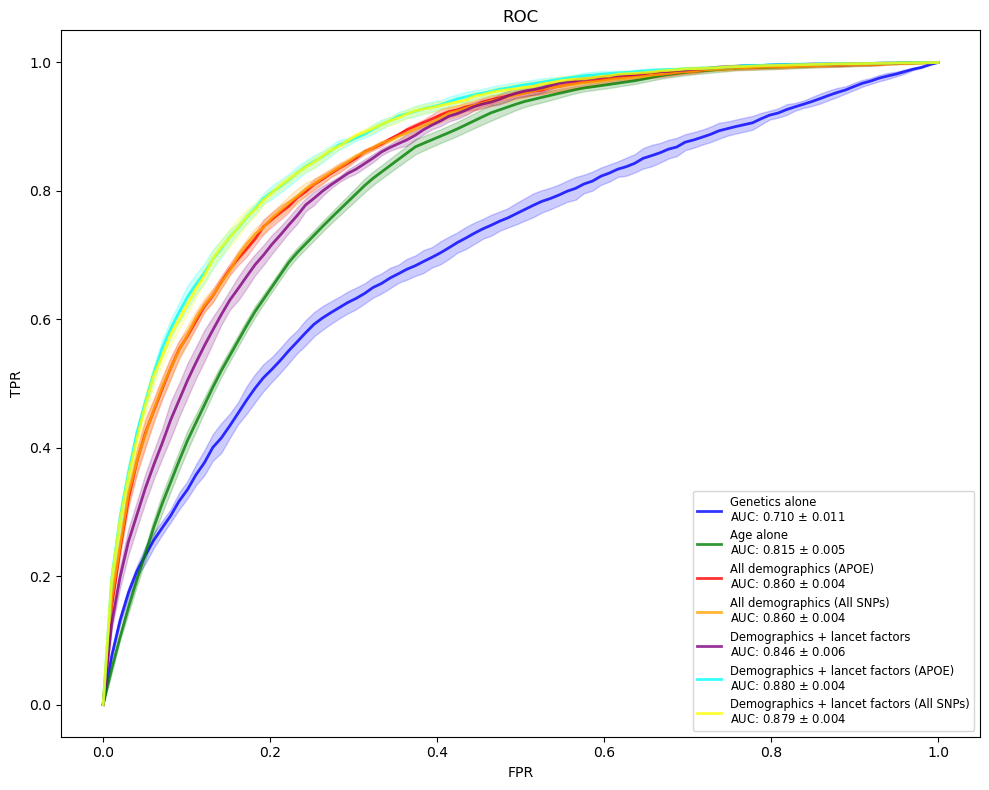

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

def mean_roc_curve(true_labels_list, predicted_probs_list):
    """
    Calculate the mean ROC curve from multiple ROC curves.

    Args:
    true_labels_list (list): List of true label arrays.
    predicted_probs_list (list): List of predicted probability arrays.

    Returns:
    tuple: Mean TPR, std TPR, mean AUC, std AUC.
    """
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    auc_l = []
    auc_maxfpr025_l = []

    for true_labels, predicted_probs in zip(true_labels_list, predicted_probs_list):
        rocauc = roc_auc_score(true_labels, predicted_probs)
        auc_l.append(rocauc)

        rocauc_maxfpr025 = roc_auc_score(true_labels, predicted_probs, max_fpr=0.25)
        auc_maxfpr025_l.append(rocauc_maxfpr025)

        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    # Compute mean and standard deviation of TPRs
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    # Calculate mean AUC and std AUC
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auc_l)

    mean_auc_maxfpr025 = np.mean(auc_maxfpr025_l)
    std_auc_maxfpr025 = np.std(auc_maxfpr025_l)

    return mean_fpr, mean_tpr, std_tpr, mean_auc, std_auc, mean_auc_maxfpr025, std_auc_maxfpr025

def extract_true_pred(exp):
    # exp = "./results/65up_age_sex/"
    pred = "test_labels_predictions.parquet"

    preds = []
    trues = []

    for folder in os.listdir(exp):
        folder_path = os.path.join(exp, folder)
        if os.path.isdir(folder_path):
            file_path = os.path.join(folder_path, pred)
            if os.path.isfile(file_path):
                df = pd.read_parquet(file_path, engine = 'fastparquet')
                predictions_df = df.y_pred
                trues_df = df.y_test

                preds.append(predictions_df)
                trues.append(trues_df)
    
    return preds, trues

experiments = [
    './results/LDE_only',
    './results_all/age_alone/none/allages/AD/lgbm',
    './results_all/all_demographics/apoe/allages/AD/lgbm',
    './results_all/all_demographics/LDE/allages/AD/lgbm',
    './results_all/demographics_lancet2024/none/allages/AD/lgbm',
    './results_all/demographics_lancet2024/apoe/allages/AD/lgbm',
    './results_all/demographics_lancet2024/LDE/allages/AD/lgbm'
]

name_map = {
    'LDE_only': 'Genetics alone',
    'age_alone': 'Age alone',
    'all_demographics': 'All demographics',
    'demographics_lancet2024': 'Demographics + lancet factors',
}

genes_map = {
    'apoe': 'APOE',
    'LDE': 'All SNPs',
}

def plot_roc_curve(experiments): 
    fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(experiments)): 
        preds, trues = extract_true_pred(experiments[i])

        (   mean_fpr,
            mean_tpr,
            std_tpr,
            mean_auc,
            std_auc,
            mean_auc_maxfpr025,
            std_auc_maxfpr025,
        ) = mean_roc_curve(trues, preds)

        colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'yellow']

        # Extract experiment parts
        parts = experiments[i].split('/')
        # Get main title from name_map if possible
        main_key = parts[2]
        title = name_map.get(main_key, main_key)
        # Add additional info from genes_map if available
        if len(parts) > 3 and parts[3] != 'none':
            gene_key = parts[3]
            gene_label = genes_map.get(gene_key, gene_key)
            title += f" ({gene_label})"
        # # Only add extra info to title if the experiment path has enough parts
        # parts = experiments[i].split('/')
        # if len(parts) > 3 and parts[3] != 'none':
        #     title += f" ({parts[3]})"

        label = f"{title}\nAUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}"
        ax.plot(mean_fpr, mean_tpr, color=colors[i], label=label, lw=2, alpha=0.8)

        # Plot standard deviation
        tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
        tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tpr_lower, tpr_upper, color=colors[i], alpha=0.2)

    ax.legend(loc='lower right', fontsize='small')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC")
    plt.tight_layout()
    plt.show()

plot_roc_curve(experiments)

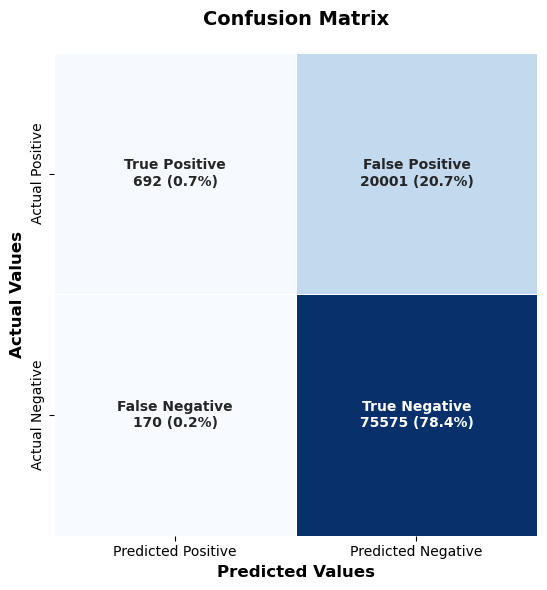

In [3]:
# CONFUSION MATRIX
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def generate_conf_mtx(path): 
    metrics = pd.read_csv(f'{path}/summary_stats/metrics.txt', header=None).T
    metrics.columns = metrics.iloc[0]
    metrics = metrics.drop(0).reset_index(drop=True)
    
    # Convert to numeric
    for val in ['TN', 'FP', 'FN', 'TP']:
        metrics[val] = pd.to_numeric(metrics[val], errors='coerce')

    # Calculate mean values across folds
    array = {val: metrics[val].mean() for val in ['TN', 'FP', 'FN', 'TP']}

    # Create confusion matrix in standard format: [[TP, FP], [FN, TN]]
    conf_matrix = np.array([[array['TP'], array['FP']],
                            [array['FN'], array['TN']]])
    
    # Calculate percentages
    total = conf_matrix.sum()
    percent_matrix = conf_matrix / total * 100

    # Create labels with counts and percentages
    labels = np.array([
        [f"True Positive\n{conf_matrix[0,0]:.0f} ({percent_matrix[0,0]:.1f}%)", 
         f"False Positive\n{conf_matrix[0,1]:.0f} ({percent_matrix[0,1]:.1f}%)"],
        [f"False Negative\n{conf_matrix[1,0]:.0f} ({percent_matrix[1,0]:.1f}%)", 
         f"True Negative\n{conf_matrix[1,1]:.0f} ({percent_matrix[1,1]:.1f}%)"]
    ])

    # Create the plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_matrix, 
                     annot=labels, 
                     fmt='', 
                     cmap='Blues', 
                     cbar=False,
                     xticklabels=['Predicted Positive', 'Predicted Negative'],
                     yticklabels=['Actual Positive', 'Actual Negative'],
                     square=True,
                     linewidths=0.5)
    
    ax.set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual Values', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    
    # Improve text formatting
    for text in ax.texts:
        text.set_fontsize(10)
        text.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()

generate_conf_mtx('./results_all/demographics_lancet2024/LDE/allages/AD/lgbm')

Processing experiment: ./results/LDE_only
Processing experiment: ./results_all/age_alone/none/allages/AD/lgbm
Processing experiment: ./results_all/all_demographics/apoe/allages/AD/lgbm
Processing experiment: ./results_all/all_demographics/LDE/allages/AD/lgbm
Processing experiment: ./results_all/demographics_lancet2024/none/allages/AD/lgbm
Processing experiment: ./results_all/demographics_lancet2024/apoe/allages/AD/lgbm
Processing experiment: ./results_all/demographics_lancet2024/LDE/allages/AD/lgbm


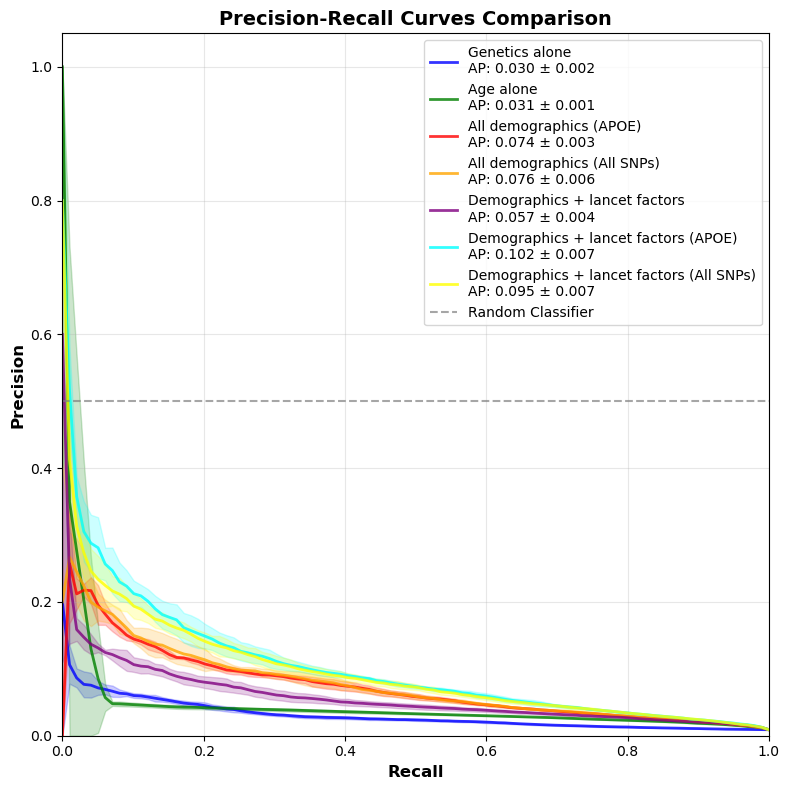

In [4]:
# precision recall curves for multiple experiments
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

experiments = [
    './results/LDE_only',
    './results_all/age_alone/none/allages/AD/lgbm',
    './results_all/all_demographics/apoe/allages/AD/lgbm',
    './results_all/all_demographics/LDE/allages/AD/lgbm',
    './results_all/demographics_lancet2024/none/allages/AD/lgbm',
    './results_all/demographics_lancet2024/apoe/allages/AD/lgbm',
    './results_all/demographics_lancet2024/LDE/allages/AD/lgbm'
]

def mean_pr_curve(true_labels_list, predicted_probs_list):
    """
    Calculate the mean Precision-Recall curve from multiple PR curves.
    """
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    ap_scores = []
    
    for true_labels, predicted_probs in zip(true_labels_list, predicted_probs_list):
        # Calculate AP score
        ap = average_precision_score(true_labels, predicted_probs)
        ap_scores.append(ap)
        
        # Calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(true_labels, predicted_probs)
        
        # Interpolate precision at standard recall values
        interp_precision = np.interp(mean_recall[::-1], recall[::-1], precision[::-1])[::-1]
        precisions.append(interp_precision)
    
    # Compute mean and standard deviation
    mean_precision = np.mean(precisions, axis=0)
    std_precision = np.std(precisions, axis=0)
    mean_ap = np.mean(ap_scores)
    std_ap = np.std(ap_scores)
    
    return mean_precision, std_precision, mean_recall, mean_ap, std_ap

def plot_multiple_pr_curves(experiments):
    """Plot multiple Precision-Recall curves for different experiments."""
    
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'yellow']
    
    plt.figure(figsize=(8, 8))
    
    for i, exp_path in enumerate(experiments):
        print(f"Processing experiment: {exp_path}")
        
        try:
            # Extract predictions and true labels
            preds, trues = extract_true_pred(exp_path)
            
            if len(preds) == 0 or len(trues) == 0:
                print(f"No data found for {exp_path}")
                continue
            
            # Calculate mean PR curve
            mean_precision, std_precision, mean_recall, mean_ap, std_ap = mean_pr_curve(trues, preds)
            
            # Extract experiment title
            parts = exp_path.split('/')
            main_key = parts[2] if len(parts) > 2 else exp_path
            title = name_map.get(main_key, main_key)
            
            # Add genetic info if available
            if len(parts) > 3 and parts[3] != 'none':
                gene_key = parts[3]
                gene_label = genes_map.get(gene_key, gene_key)
                title += f" ({gene_label})"
            
            # Plot the curve
            color = colors[i % len(colors)]
            label = f"{title}\nAP: {mean_ap:.3f} ± {std_ap:.3f}"
            
            plt.plot(mean_recall, mean_precision, 
                    color=color, 
                    label=label, 
                    lw=2, 
                    alpha=0.8)
            
            # Add confidence interval
            plt.fill_between(mean_recall,
                           np.maximum(mean_precision - std_precision, 0),
                           np.minimum(mean_precision + std_precision, 1),
                           color=color, 
                           alpha=0.2)
            
        except Exception as e:
            print(f"Error processing {exp_path}: {e}")
            continue
    
    # Add baseline (random classifier)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random Classifier')
    
    plt.xlabel('Recall', fontsize=12, fontweight='bold')
    plt.ylabel('Precision', fontsize=12, fontweight='bold')
    plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()

# Plot multiple PR curves using your experiments list
plot_multiple_pr_curves(experiments)

Processing experiment: ./results/LDE_only
Processing experiment: ./results_all/age_alone/none/allages/AD/lgbm
Processing experiment: ./results_all/all_demographics/apoe/allages/AD/lgbm
Processing experiment: ./results_all/all_demographics/LDE/allages/AD/lgbm
Processing experiment: ./results_all/demographics_lancet2024/none/allages/AD/lgbm
Processing experiment: ./results_all/demographics_lancet2024/apoe/allages/AD/lgbm
Processing experiment: ./results_all/demographics_lancet2024/LDE/allages/AD/lgbm


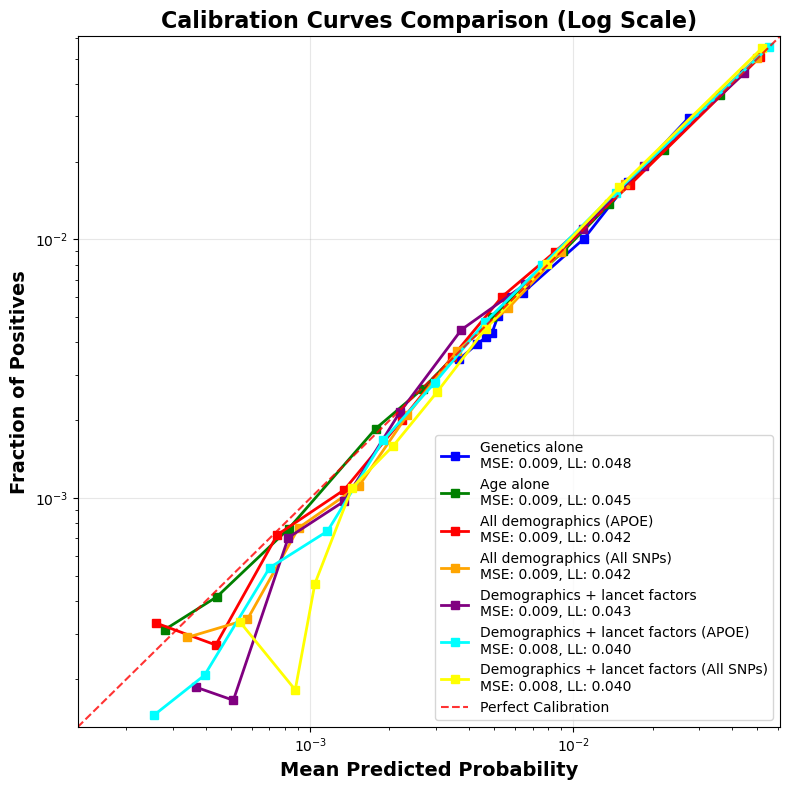

In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error, log_loss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_multiple_calibration_curves(experiments):
    """Plot multiple calibration curves for different experiments with log scale and enhanced metrics."""
    
    #colors = ['#ff0000', '#ff7f00', '#ffae00', '#fff500', '#a2ff00', 
    #          '#00ff29', '#00ffce', '#00c9ff', '#2700ff', '#ab00ff']
    
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'yellow']
    
    # Initialize plot with log scale
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel("Mean Predicted Probability", fontsize=14, fontweight='bold')
    ax.set_ylabel("Fraction of Positives", fontsize=14, fontweight='bold')
    
    # Set logarithmic scales
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    pred_l = []
    true_l = []
    
    for i, exp_path in enumerate(experiments):
        print(f"Processing experiment: {exp_path}")
        
        try:
            # Extract predictions and true labels from all folds
            preds, trues = extract_true_pred(exp_path)
            
            if len(preds) == 0 or len(trues) == 0:
                print(f"No data found for {exp_path}")
                continue
            
            # Combine all folds
            all_preds = np.concatenate(preds)
            all_trues = np.concatenate(trues)
            
            # Calculate calibration curve with quantile strategy
            prob_true, prob_pred = calibration_curve(all_trues, all_preds, n_bins=10, strategy="quantile")
            
            # Remove zero values to avoid log(0) issues
            if np.min(prob_true) == 0:
                non_zero_indices = prob_true > 0
                prob_true = prob_true[non_zero_indices]
                prob_pred = prob_pred[non_zero_indices]
            
            if np.min(prob_pred) == 0:
                non_zero_indices = prob_pred > 0
                prob_true = prob_true[non_zero_indices]
                prob_pred = prob_pred[non_zero_indices]
            
            # Store for plot limits
            pred_l.extend(prob_pred)
            true_l.extend(prob_true)
            
            # Extract experiment title
            parts = exp_path.split('/')
            main_key = parts[2] if len(parts) > 2 else exp_path
            title = name_map.get(main_key, main_key)
            
            # Add genetic info if available
            if len(parts) > 3 and parts[3] != 'none':
                gene_key = parts[3]
                gene_label = genes_map.get(gene_key, gene_key)
                title += f" ({gene_label})"
            
            # Calculate additional metrics
            mse = mean_squared_error(all_trues, all_preds)
            ll = log_loss(all_trues, all_preds)
            
            # Plot the curve with enhanced styling
            color = colors[i % len(colors)]
            label = f"{title}\nMSE: {mse:.3f}, LL: {ll:.3f}"
            
            ax.plot(prob_pred, prob_true, 
                   color=color, 
                   marker='s', 
                   label=label, 
                   lw=2,
                   markersize=6)
            
        except Exception as e:
            print(f"Error processing {exp_path}: {e}")
            continue
    
    # Add diagonal reference line
    if pred_l and true_l:
        min_val = min(min(pred_l), min(true_l)) * 0.9
        max_val = max(max(pred_l), max(true_l)) * 1.1
        ax.plot([min_val, max_val], [min_val, max_val], 
               linestyle='--', color='red', alpha=0.8, label='Perfect Calibration')
        
        # Set plot limits
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
    
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.title('Calibration Curves Comparison (Log Scale)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Alternative version with linear scale (similar to your original)
def plot_multiple_calibration_curves_linear(experiments):
    """Plot multiple calibration curves with linear scale and Brier scores."""
    
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'brown']
    
    plt.figure(figsize=(8, 8))
    
    for i, exp_path in enumerate(experiments):
        print(f"Processing experiment: {exp_path}")
        
        try:
            # Extract predictions and true labels from all folds
            preds, trues = extract_true_pred(exp_path)
            
            if len(preds) == 0 or len(trues) == 0:
                print(f"No data found for {exp_path}")
                continue
            
            # Combine all folds
            all_preds = np.concatenate(preds)
            all_trues = np.concatenate(trues)
            
            # Calculate calibration curve
            prob_true, prob_pred = calibration_curve(all_trues, all_preds, n_bins=10)
            
            # Extract experiment title
            parts = exp_path.split('/')
            main_key = parts[2] if len(parts) > 2 else exp_path
            title = name_map.get(main_key, main_key)
            
            if len(parts) > 3 and parts[3] != 'none':
                gene_key = parts[3]
                gene_label = genes_map.get(gene_key, gene_key)
                title += f" ({gene_label})"
            
            # Calculate Brier score (lower is better)
            brier_score = np.mean((all_preds - all_trues) ** 2)
            
            # Plot
            color = colors[i % len(colors)]
            label = f"{title}\nBrier: {brier_score:.3f}"
            
            plt.plot(prob_pred, prob_true, 
                    marker='o', 
                    color=color, 
                    label=label, 
                    lw=2,
                    markersize=6)
            
        except Exception as e:
            print(f"Error processing {exp_path}: {e}")
            continue
    
    # Add perfect calibration line
    plt.plot([0, 1], [0, 1], 
             linestyle='--', 
             color='gray', 
             label='Perfect Calibration',
             alpha=0.8)
    
    plt.xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
    plt.ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
    plt.title('Calibration Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.tight_layout()
    plt.show()

# Use either version:
plot_multiple_calibration_curves(experiments)        # Log scale with MSE + Log Loss
# plot_multiple_calibration_curves_linear(experiments) # Linear scale with Brier score

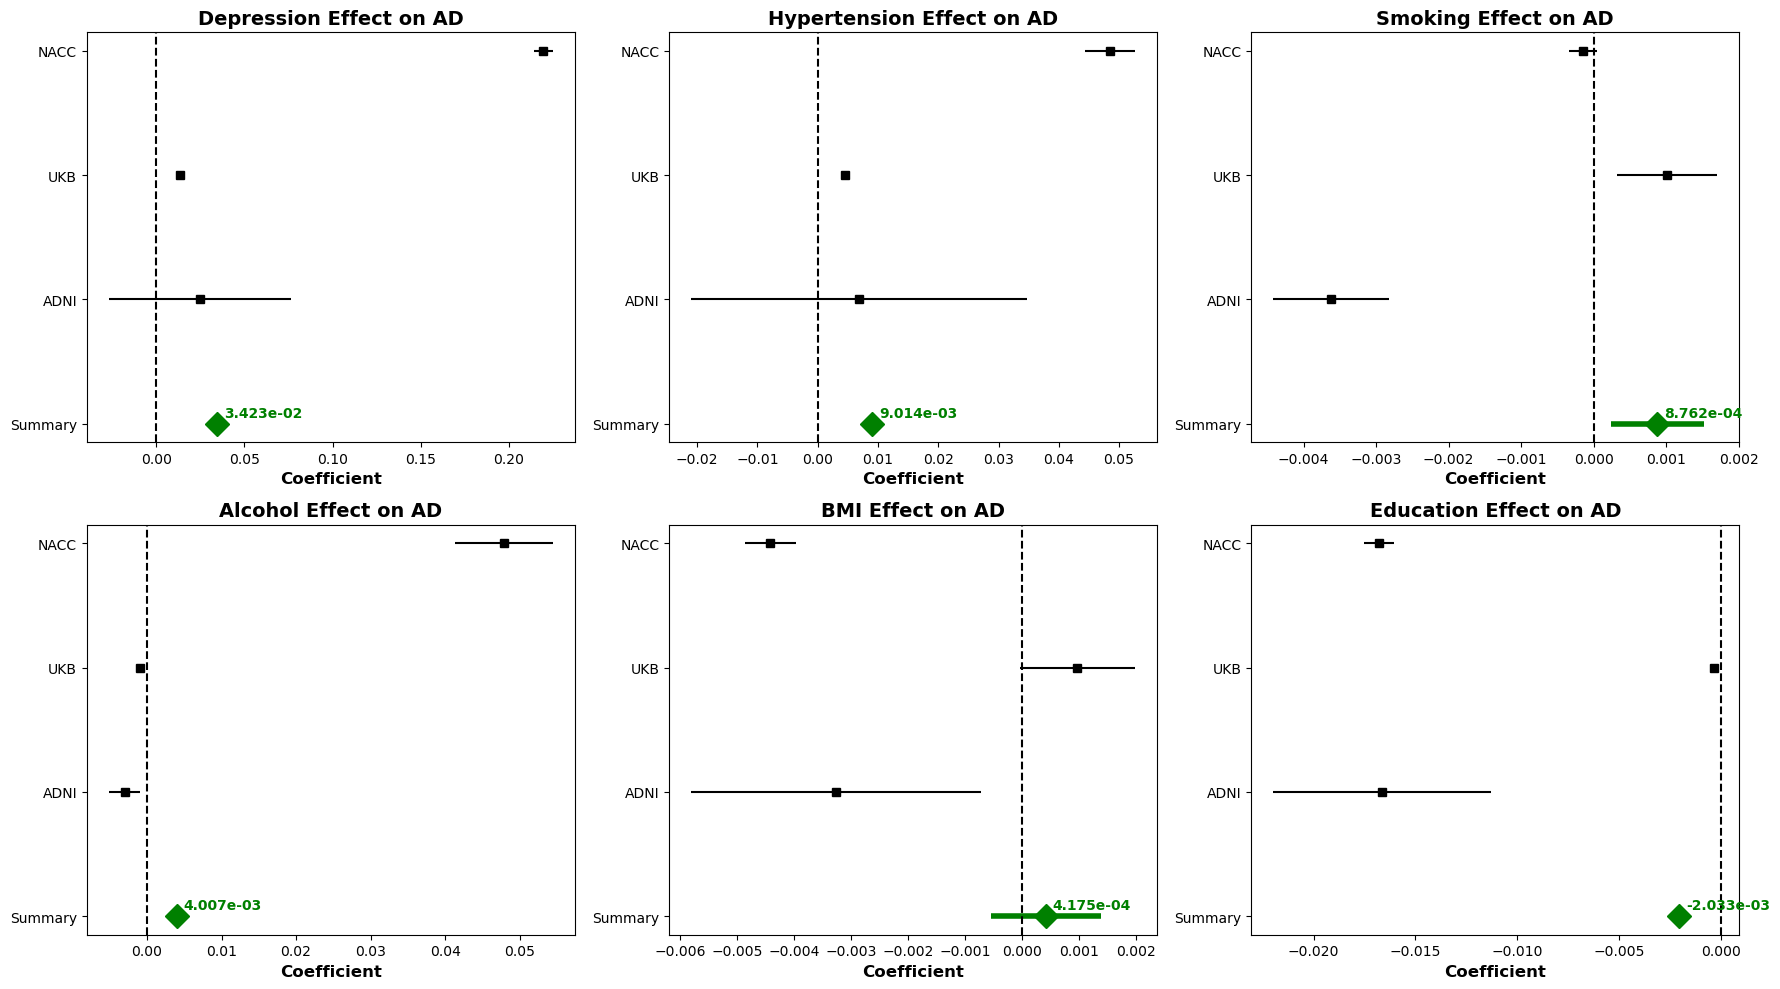

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Feature Mapping
# --------------------------
features = ['Depression', 'Hypertension', 'Smoking', 'Alcohol', 'BMI', 'Education'] # Hearing Loss

UKB_features_map = {
    'Depression': 'depression',
    'Hypertension': 'hypertension',
    'Smoking': '20161-0.0',
    'Alcohol': 'alcohol_consumption',
    #'Hearing Loss': 'hearing_loss',
    'BMI': 'obesity',
    'Education': 'education_years'
}

NACC_features_map = {
    'Depression': 'DEPD',
    'Hypertension': 'HYPERTEN',
    'Smoking': 'SMOKYRS',
    'Alcohol': 'ALCOHOL',
    #'Hearing Loss': 'HEARING',
    'BMI': 'NACCBMI',
    'Education': 'EDUC'
}

ADNI_features_map = {
    'Depression': 'GDTOTAL',
    'Hypertension': 'HMHYPERT',
    'Smoking': 'MH16BSMOK',
    'Alcohol': 'MH14BALCH',
    'BMI': 'bmi', 
    'Education': 'PTEDUCAT'
}

# --------------------------
# Load Data
# --------------------------
ukb_df = pd.read_csv('./double_ml/ukbiobank_lancet.txt')  # replace with actual path
nacc_df = pd.read_csv('../NACC/double_ml/nacc_lancet_meta.txt')  # replace with actual path
adni_df = pd.read_csv('../ADNI/double_ml/adni_lancet_meta.txt')  # replace with actual path


# Ensure coef bounds are calculated if not already
for df in [ukb_df, nacc_df, adni_df]:
    if '2.5 %' not in df.columns or '97.5 %' not in df.columns:
        df['2.5 %'] = df['coef'] - 1.96 * df['std err']
        df['97.5 %'] = df['coef'] + 1.96 * df['std err']

datasets = ['NACC', 'UKB', 'ADNI']

# --------------------------
# Plotting
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ukb_id = UKB_features_map[feature]
    nacc_id = NACC_features_map[feature]
    adni_id = ADNI_features_map[feature]

    # Retrieve UKB stats
    ukb_row = ukb_df[ukb_df['test_id'] == ukb_id].iloc[0]
    ukb_coef, ukb_lower, ukb_upper = ukb_row['coef'], ukb_row['2.5 %'], ukb_row['97.5 %']

    # Retrieve NACC stats
    nacc_row = nacc_df[nacc_df['test_id'] == nacc_id].iloc[0]
    nacc_coef, nacc_lower, nacc_upper = nacc_row['coef'], nacc_row['2.5 %'], nacc_row['97.5 %']

    # Retrieve ADNI stats
    adni_row = adni_df[adni_df['test_id'] == adni_id].iloc[0]
    adni_coef, adni_lower, adni_upper = adni_row['coef'], adni_row['2.5 %'], adni_row['97.5 %']

    coefs = [nacc_coef, ukb_coef, adni_coef]
    lower_bounds = [nacc_lower, ukb_lower, adni_lower]
    upper_bounds = [nacc_upper, ukb_upper, adni_upper]

    y_pos = np.arange(len(datasets), 0, -1)

    ax = axes[idx]

    for i in range(len(coefs)):
        ax.errorbar(coefs[i], y_pos[i],
                    xerr=[[coefs[i] - lower_bounds[i]], [upper_bounds[i] - coefs[i]]],
                    fmt='s', color='black')

    # Meta-analysis summary (weighted mean)
    # NACC size = 54025, UKB size = 481983, ADNI size = 1878
    summary_coef = (coefs[0] * 54025 + coefs[1] * 481983 + coefs[2] * 1878) / (54025 + 481983 + 1878)
    summary_lower = (lower_bounds[0] * 54025 + lower_bounds[1] * 481983 + lower_bounds[2] * 1878) / (54025 + 481983 + 1878)
    summary_upper = (upper_bounds[0] * 54025 + upper_bounds[1] * 481983 + upper_bounds[2] * 1878) / (54025 + 481983 + 1878)

    ax.plot(summary_coef, 0, 'D', markersize=12, color='green', label='Summary')
    ax.hlines(0, summary_lower, summary_upper, color='green', linewidth=4)
    # Annotate the summary coefficient value
    ax.annotate(f"{summary_coef:.3e}", (summary_coef, 0), xytext=(5, 5), textcoords='offset points', fontsize=10, color='green', fontweight='bold')

    ax.set_yticks(list(y_pos) + [0])
    ax.set_yticklabels(datasets + ['Summary'])
    ax.axvline(0, color='black', linestyle='dashed')
    ax.set_xlabel('Coefficient', fontsize=12, fontweight='bold')
    ax.set_title(f'{feature} Effect on AD', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()




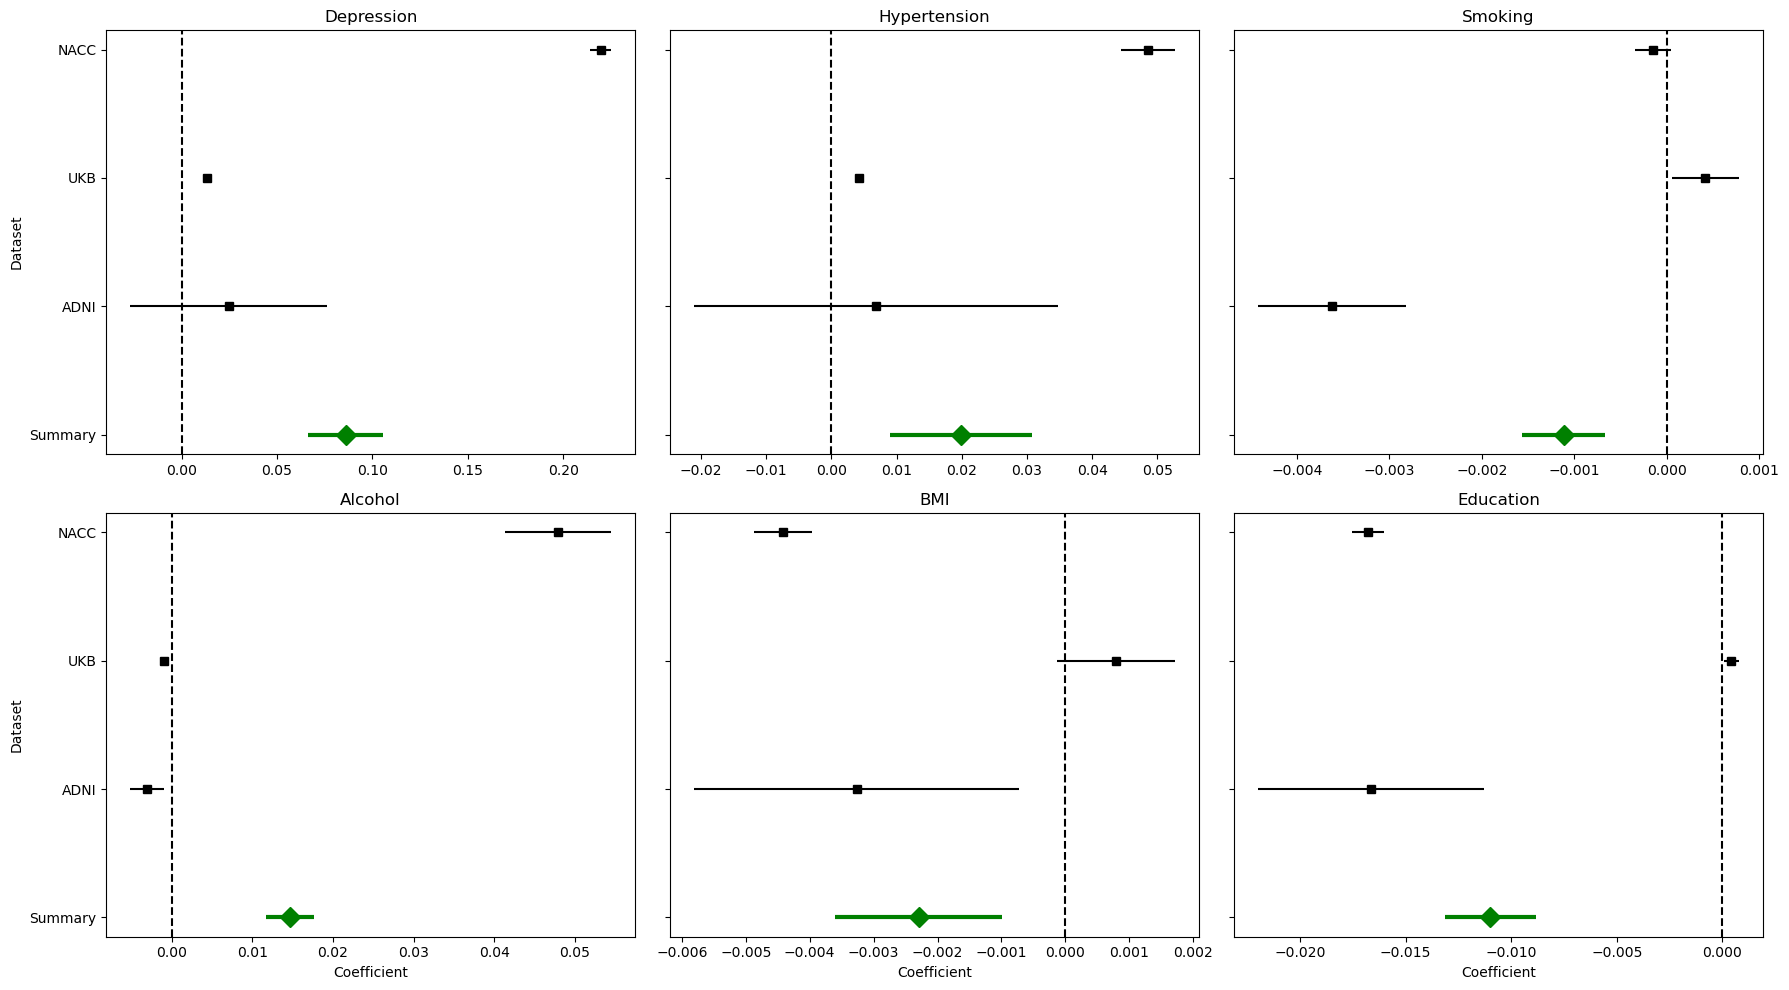

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)
axes = axes.flatten()

for idx, feature in enumerate(features):
    ukb_id = UKB_features_map[feature]
    nacc_id = NACC_features_map[feature]
    adni_id = ADNI_features_map[feature]

    # Retrieve UKB stats
    ukb_row = ukb_df[ukb_df['test_id'] == ukb_id].iloc[0]
    ukb_coef, ukb_lower, ukb_upper = ukb_row['coef'], ukb_row['2.5 %'], ukb_row['97.5 %']

    # Retrieve NACC stats
    nacc_row = nacc_df[nacc_df['test_id'] == nacc_id].iloc[0]
    nacc_coef, nacc_lower, nacc_upper = nacc_row['coef'], nacc_row['2.5 %'], nacc_row['97.5 %']

    # Retrieve ADNI stats
    adni_row = adni_df[adni_df['test_id'] == adni_id].iloc[0]
    adni_coef, adni_lower, adni_upper = adni_row['coef'], adni_row['2.5 %'], adni_row['97.5 %']

    coefs = [nacc_coef, ukb_coef, adni_coef]
    lower_bounds = [nacc_lower, ukb_lower, adni_lower]
    upper_bounds = [nacc_upper, ukb_upper, adni_upper]

    y_pos = np.arange(len(datasets), 0, -1)

    ax = axes[idx]
    for i in range(len(coefs)):
        ax.errorbar(coefs[i], y_pos[i],
                    xerr=[[coefs[i] - lower_bounds[i]], [upper_bounds[i] - coefs[i]]],
                    fmt='s', color='black')

    # Meta-analysis summary (mean of coefs as placeholder)
    summary_coef = np.mean(coefs)
    summary_lower = np.mean(lower_bounds)
    summary_upper = np.mean(upper_bounds)

    ax.plot(summary_coef, 0, 'D', markersize=10, color='green', label='Summary')
    ax.hlines(0, summary_lower, summary_upper, color='green', linewidth=3)

    ax.set_yticks(list(y_pos) + [0])
    ax.set_yticklabels(datasets + ['Summary'])
    ax.axvline(0, color='black', linestyle='dashed')
    ax.set_title(f'{feature}')
    if idx % 3 == 0:
        ax.set_ylabel('Dataset')
    if idx >= 3:
        ax.set_xlabel('Coefficient')

plt.tight_layout()
plt.show()
